# **Data pipeline**
<a target="_blank" href="https://colab.research.google.com/github/raphaelrubrice/scVAE_mva2025/blob/main/data_pipeline.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## **Colab setup**

In [16]:
!git clone https://github.com/raphaelrubrice/scVAE_mva2025.git
%cd scVAE_mva2025
!pip install -r requirements.txt

Cloning into 'scVAE_mva2025'...
remote: Enumerating objects: 318, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 318 (delta 104), reused 110 (delta 53), pack-reused 131 (from 1)
Receiving objects: 100% (318/318), 977.41 KiB | 20.80 MiB/s, done.
Resolving deltas: 100% (168/168), done.
/content/scVAE_mva2025/scVAE_mva2025/scVAE_mva2025


### Test Downloads

In [17]:
from data_pipeline.src.downloader import run_downloads

run_downloads()


Saving extracted PBMC datasets to: /content/scVAE_mva2025/data_pipeline/data/pbmc_raw

✓ Already downloaded/extracted: /content/scVAE_mva2025/data_pipeline/data/pbmc_raw/CD34
------------------------------------------------------------
✓ Already downloaded/extracted: /content/scVAE_mva2025/data_pipeline/data/pbmc_raw/CD19_B
------------------------------------------------------------
✓ Already downloaded/extracted: /content/scVAE_mva2025/data_pipeline/data/pbmc_raw/CD56_NK
------------------------------------------------------------
✓ Already downloaded/extracted: /content/scVAE_mva2025/data_pipeline/data/pbmc_raw/CD4_helper
------------------------------------------------------------
✓ Already downloaded/extracted: /content/scVAE_mva2025/data_pipeline/data/pbmc_raw/CD4_CD25
------------------------------------------------------------
✓ Already downloaded/extracted: /content/scVAE_mva2025/data_pipeline/data/pbmc_raw/CD4_CD45RA_CD25neg
--------------------------------------------------

In [18]:
from data_pipeline.src.config import DATASETS
from data_pipeline.src.load_anndata import load_anndata
from pathlib import Path

folder = Path("data_pipeline/data/pbmc_raw/CD4_CD45RO")
meta = DATASETS["CD4_CD45RO"]

adata = load_anndata(folder, meta)
adata

FileNotFoundError: Could not locate matrix.mtx below data_pipeline/data/pbmc_raw/CD4_CD45RO

In [ ]:
from data_pipeline.src.combine import run_combine

combined, collection = run_combine(
    do_write_shards=True,
    write_combined=True,
    harmonize_var=False
)

In [ ]:
import scanpy as sc
adata_combined = sc.read_h5ad("data_pipeline/data/pbmc_processed/pbmc_combined.h5ad")
adata_combined.obs_names_make_unique()
adata_combined

In [ ]:
import pandas as pd

# boolean mask of duplicates
dupe_mask = adata_combined.obs_names.duplicated(keep=False)

# show all duplicated entries
adata_combined.obs_names[dupe_mask]


## TSNE

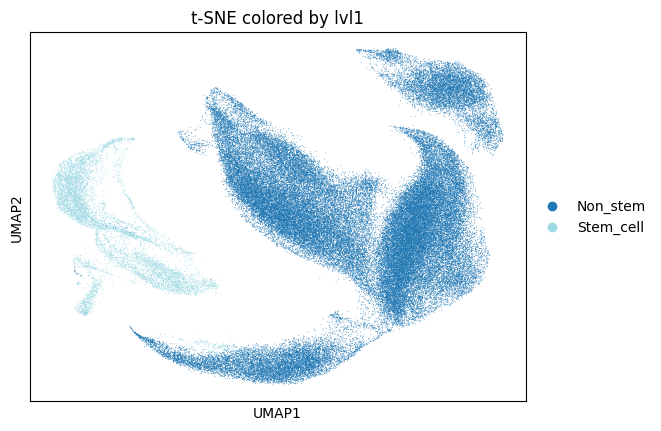

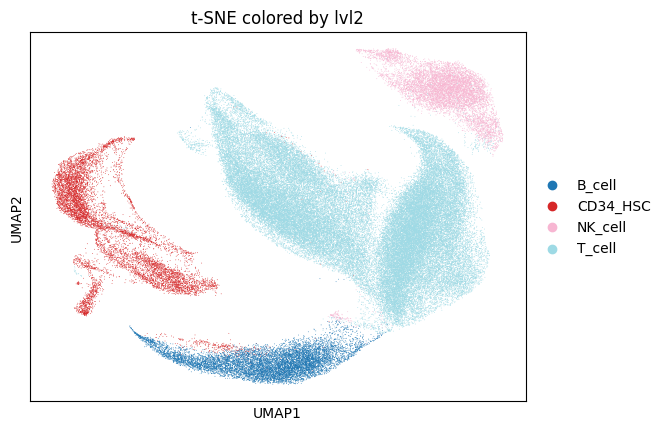

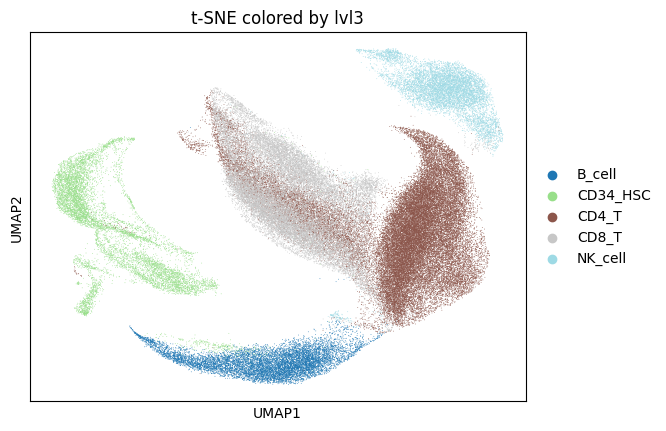

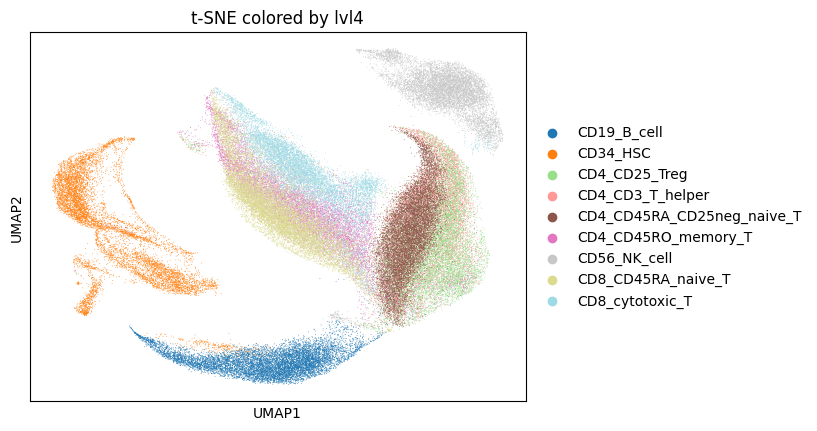

In [9]:
import scanpy as sc

sc.tl.pca(adata_combined, svd_solver='arpack')

sc.pp.neighbors(adata_combined, use_rep='X_pca')

sc.tl.umap(adata_combined)

# Plot each hierarchy level
for lvl in ["lvl1", "lvl2", "lvl3", "lvl4"]:
    sc.pl.umap(
        adata_combined,
        color=f"cell_type_{lvl}",
        palette='tab20',  # enough colors for level 4
        title=f"t-SNE colored by {lvl}",
        legend_loc='right margin'
    )

## Training

In [ ]:
from data_pipeline.src.dataloader import build_dataloaders

train_loader, val_loader, test_loader = build_dataloaders(
    shard_dir="data_pipeline/data/pbmc_processed/shards",
    label_maps_path="data_pipeline/data/pbmc_processed/label_maps.json",
    batch_size=512,
    one_hot=True,
)

for i, batch in enumerate(train_loader):
        print("Example batch shapes:")
        print("X:", batch["X"].shape, "y1:", batch["y1"].shape, "y4:", batch["y4"].shape)
        break

/usr/local/lib/python3.12/dist-packages/legacy_api_wrap/__init__.py:88: UserWarning: Observation names are not unique.
  return fn(*args_all, **kw)


✓ Built AnnCollection with 92043 total cells.
Split: train=74554, val=8283, test=9206
✓ Train=74554, Val=8283, Test=9206
Example batch shapes:
X: torch.Size([512, 1, 32738]) y1: torch.Size([512, 1, 2]) y4: torch.Size([512, 1, 9])


In [ ]:
from mixture_vae.mvae import ind_MoMVAE

from mixture_vae.distributions import (
    NormalDistribution,
    UniformDistribution,
    NegativeBinomial
)

from mixture_vae.training import (
    training_mvae
)

import torch

In [ ]:
model = ind_MoMVAE(
    [
        {
          "input_dim": batch["X"].shape[-1],
          "hidden_dim": 20,
          "n_components": K,
          "n_layers": 3,
          "prior_latent": NormalDistribution(
              {
              "mu": torch.zeros((1, 20)),
              "std": torch.ones((1, 20))
              }
          ),
          "prior_input": NegativeBinomial(
              {
                "p":  0.5 * torch.ones((1, batch["X"].shape[-1])),
                "r": torch.mean(batch["X"], dim=0).reshape(1,-1)
              }
          ),
          "prior_categorical": UniformDistribution(
              {
                "a": torch.zeros((1, K)),
                "b": torch.ones((1, K))
              }
          ),
          "posterior_latent": NormalDistribution(
              {
              "mu": torch.zeros((1, 20)),
              "std": torch.ones((1, 20))
              }
          ),
        }
        for K in [2, 4, 8]
    ]
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 50
BETA_KL = 0.5
WARMUP = None
PATIENCE = 5
TOL = 5e-3

In [ ]:
model, losses, all_parts, clusters, all_betas = training_mvae(
    dataloader=train_loader,
    val_dataloader=val_loader,
    model=model,
    optimizer=optimizer,
    epochs=EPOCHS,
    beta_kl=BETA_KL,
    patience=PATIENCE,
    tol=TOL,
    model_type=1
)

TRAINING:   0%|          | 0/50 [00:37<?, ?it/s]


KeyError: 0